In [1]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt


def extractSkin(image):
    # Taking a copy of the image
    img = image.copy()
    # Converting from BGR Colours Space to HSV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Defining HSV Threadholds
    lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
    upper_threshold = np.array([20, 255, 255], dtype=np.uint8)

    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

    # Extracting skin from the threshold mask
    skin = cv2.bitwise_and(img, img, mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)


def removeBlack(estimator_labels, estimator_cluster):

    # Check for black
    hasBlack = False

    # Get the total number of occurance for each color
    occurance_counter = Counter(estimator_labels)

    # Quick lambda function to compare to lists
    def compare(x, y): return Counter(x) == Counter(y)

    # Loop through the most common occuring color
    for x in occurance_counter.most_common(len(estimator_cluster)):

        # Quick List comprehension to convert each of RBG Numbers to int
        color = [int(i) for i in estimator_cluster[x[0]].tolist()]

        # Check if the color is [0,0,0] that if it is black
        if compare(color, [0, 0, 0]) == True:
            # delete the occurance
            del occurance_counter[x[0]]
            # remove the cluster
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster, x[0], 0)
            break

    return (occurance_counter, estimator_cluster, hasBlack)


def getColorInformation(estimator_labels, estimator_cluster, hasThresholding=False):

    # Variable to keep count of the occurance of each color predicted
    occurance_counter = None

    # Output list variable to return
    colorInformation = []

    # Check for Black
    hasBlack = False

    # If a mask has be applied, remove th black
    if hasThresholding == True:

        (occurance, cluster, black) = removeBlack(
            estimator_labels, estimator_cluster)
        occurance_counter = occurance
        estimator_cluster = cluster
        hasBlack = black

    else:
        occurance_counter = Counter(estimator_labels)

    # Get the total sum of all the predicted occurances
    totalOccurance = sum(occurance_counter.values())

    # Loop through all the predicted colors
    for x in occurance_counter.most_common(len(estimator_cluster)):

        index = (int(x[0]))

        # Quick fix for index out of bound when there is no threshold
        index = (index-1) if ((hasThresholding & hasBlack)
                              & (int(index) != 0)) else index

        # Get the color number into a list
        color = estimator_cluster[index].tolist()

        # Get the percentage of each color
        color_percentage = (x[1]/totalOccurance)

        # make the dictionay of the information
        colorInfo = {"cluster_index": index, "color": color,
                     "color_percentage": color_percentage}

        # Add the dictionary to the list
        colorInformation.append(colorInfo)

    return colorInformation


def extractDominantColor(image, number_of_colors=5, hasThresholding=False):

    # Quick Fix Increase cluster counter to neglect the black(Read Article)
    if hasThresholding == True:
        number_of_colors += 1

    # Taking Copy of the image
    img = image.copy()

    # Convert Image into RGB Colours Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reshape Image
    img = img.reshape((img.shape[0]*img.shape[1]), 3)

    # Initiate KMeans Object
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)

    # Fit the image
    estimator.fit(img)

    # Get Colour Information
    colorInformation = getColorInformation(
        estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation


def plotColorBar(colorInformation):
    # Create a 500x100 black image
    color_bar = np.zeros((100, 500, 3), dtype="uint8")

    top_x = 0
    for x in colorInformation:
        bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

        color = tuple(map(int, (x['color'])))

        cv2.rectangle(color_bar, (int(top_x), 0),
                      (int(bottom_x), color_bar.shape[0]), color, -1)
        top_x = bottom_x
    return color_bar


"""## Section Two.4.2 : Putting it All together: Pretty Print
The function makes print out the color information in a readable manner
"""


def prety_print_data(color_info):
    for x in color_info:
        print(pprint.pformat(x))
        print()


"""
The below lines of code, is the implementation of the above defined function.
"""

'''
Skin Image Primary : https://raw.githubusercontent.com/octalpixel/Skin-Extraction-from-Image-and-Finding-Dominant-Color/master/82764696-open-palm-hand-gesture-of-male-hand_image_from_123rf.com.jpg
Skin Image One     : https://raw.githubusercontent.com/octalpixel/Skin-Extraction-from-Image-and-Finding-Dominant-Color/master/skin.jpg
Skin Image Two     : https://raw.githubusercontent.com/octalpixel/Skin-Extraction-from-Image-and-Finding-Dominant-Color/master/skin_2.jpg
Skin Image Three   : https://raw.githubusercontent.com/octalpixel/Skin-Extraction-from-Image-and-Finding-Dominant-Color/master/Human-Hands-Front-Back-Image-From-Wikipedia.jpg
'''


# Get Image from URL. If you want to upload an image file and use that comment the below code and replace with  image=cv2.imread("FILE_NAME")
# image = imutils.url_to_image(
#     "https://raw.githubusercontent.com/octalpixel/Skin-Extraction-from-Image-and-Finding-Dominant-Color/master/82764696-open-palm-hand-gesture-of-male-hand_image_from_123rf.com.jpg")



'\nSkin Image Primary : https://raw.githubusercontent.com/octalpixel/Skin-Extraction-from-Image-and-Finding-Dominant-Color/master/82764696-open-palm-hand-gesture-of-male-hand_image_from_123rf.com.jpg\nSkin Image One     : https://raw.githubusercontent.com/octalpixel/Skin-Extraction-from-Image-and-Finding-Dominant-Color/master/skin.jpg\nSkin Image Two     : https://raw.githubusercontent.com/octalpixel/Skin-Extraction-from-Image-and-Finding-Dominant-Color/master/skin_2.jpg\nSkin Image Three   : https://raw.githubusercontent.com/octalpixel/Skin-Extraction-from-Image-and-Finding-Dominant-Color/master/Human-Hands-Front-Back-Image-From-Wikipedia.jpg\n'

/home/itechnolabs/Projects/face/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Color Information
{'cluster_index': 0,
 'color': [205.61543478261092, 169.88347826087218, 157.695217391302],
 'color_percentage': 0.2787300820859488}

{'cluster_index': 4,
 'color': [177.71843778383518, 145.70254314259836, 135.51680290644848],
 'color_percentage': 0.26581361661033315}

{'cluster_index': 2,
 'color': [236.87632295131786, 200.2283035984306, 187.53311158149165],
 'color_percentage': 0.19990342829550942}

{'cluster_index': 3,
 'color': [145.76735168670098, 116.02016285381941, 108.13260953858162],
 'color_percentage': 0.15481651376146788}

{'cluster_index': 1,
 'color': [96.80393325387355, 74.90047675804513, 71.7461263408818],
 'color_percentage': 0.10073635924674071}

Color Bar


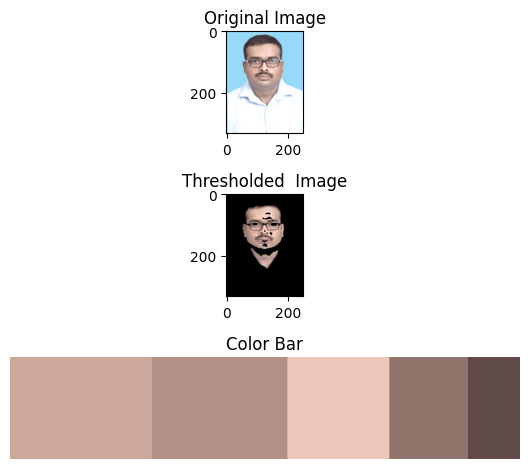

In [2]:
image = cv2.imread('profile.jpg')
# Resize image to a width of 250
image = imutils.resize(image, width=250)

# Show image
plt.subplot(3, 1, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
# plt.show()

# Apply Skin Mask
skin = extractSkin(image)

plt.subplot(3, 1, 2)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.title("Thresholded  Image")
# plt.show()

# Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors
dominantColors = extractDominantColor(skin, hasThresholding=True)

# Show in the dominant color information
print("Color Information")
prety_print_data(dominantColors)

# Show in the dominant color as bar
print("Color Bar")
colour_bar = plotColorBar(dominantColors)
plt.subplot(3, 1, 3)
plt.axis("off")
plt.imshow(colour_bar)
plt.title("Color Bar")

plt.tight_layout()
plt.show()

/home/itechnolabs/Projects/face/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Color Information
{'cluster_index': 0,
 'color': [232.32978643686215, 195.27538403895818, 176.9814162607761],
 'color_percentage': 0.3013139083668051}

{'cluster_index': 2,
 'color': [207.1197256287629, 161.05934317189963, 138.7637705258785],
 'color_percentage': 0.2178273991876007}

{'cluster_index': 4,
 'color': [172.50348258706185, 127.57189054726504, 103.99912935323306],
 'color_percentage': 0.18433294755712892}

{'cluster_index': 1,
 'color': [131.3473969898829, 88.49605230693342, 63.09708857636325],
 'color_percentage': 0.18424217668550164}

{'cluster_index': 3,
 'color': [87.72925499697146, 54.765192812437014, 34.182919442762234],
 'color_percentage': 0.11228356820296367}

Color Bar


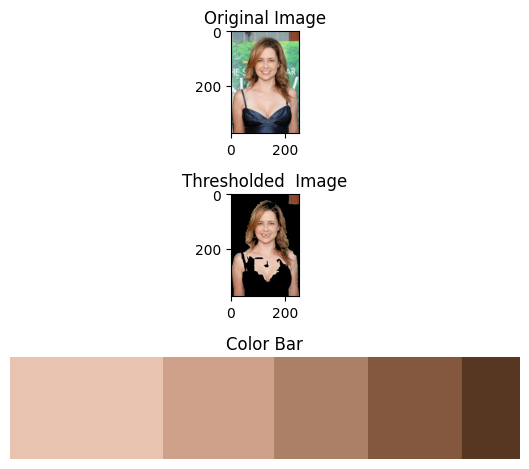

In [3]:
image = cv2.imread('download12.jpeg')
# Resize image to a width of 250
image = imutils.resize(image, width=250)

# Show image
plt.subplot(3, 1, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
# plt.show()

# Apply Skin Mask
skin = extractSkin(image)

plt.subplot(3, 1, 2)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.title("Thresholded  Image")
# plt.show()

# Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors
dominantColors = extractDominantColor(skin, hasThresholding=True)

# Show in the dominant color information
print("Color Information")
prety_print_data(dominantColors)

# Show in the dominant color as bar
print("Color Bar")
colour_bar = plotColorBar(dominantColors)
plt.subplot(3, 1, 3)
plt.axis("off")
plt.imshow(colour_bar)
plt.title("Color Bar")

plt.tight_layout()
plt.show()